In [1]:
from cluster import run_clustering
from obspy import UTCDateTime
import pandas as pd
import seaborn as sns
import numpy as np
from cc_dataset_serial import CCDataset_serial
import os

In [2]:
# Set up the configuration for clustering
config = {}

# Path to h5 files with data
# you can use wildcard "*" (e.g. if data split over
# day or year directories with same name pattern) 
# this will be the directory that clustering and 
# stacking both look for input
config["input_directories"] = "data"
# directory where to save output
config["cluster_dir"] = "clusters"
# stations, channels to consider
config["stations"] = ["ESTA"]
config["channels"] = ["HHE", "HHZ", "HHE"]
# frequency bands: Will be used to filter data
# before clustering.
config["freq_bands"]= [[4.0, 8.0]]
# filter type: "bandpass" (butterworth)
# or "cheby2_bandpass" (Chebysheff bandpass)
# filtering will be applied for clustering
config["filt_type"] = "bandpass"
# max. order
# only relevant for cheby2_bandpass filter
config["filt_maxord"] = 18

# nr. of random samples to be pulled from each file
# to be used for determining principal components
# e.g.: If there are 5 files for station G.UNM..HHZ
# then this will randomly select n_samples_each_file
# from each of them.
# if you want to use all available data, set to "all"
config["n_samples_each_file"] = 1000
# clustering is done in windows of the whole cc wave
# form (assuming that not every wiggle up to very 
# long lag is important). Windows are symmetric Tukey
# around twin_mid (in seconds, of lag)
# and with a duration of hw_factor times the 
# longest period in the resp. frequency band.
# center of window in terms of lag, seconds
config["twin_mid"] = 0.0
# halfwidth in terms of longest period
config["hw_factor"] = 10
# desired level of explaining variance by PCA
config["expl_var"] = 0.9
# n clusters to try out. 
# the final number will be based on estimating 
# the "knee" of the Bayesian information criterion 
config["nclustmax"] =  20
# print extra info or not:
config["print_debug"] = True

In [3]:
# create output directory
if not os.path.exists(config["cluster_dir"]):
    os.makedirs(config["cluster_dir"])

# run the clustering
run_clustering(config, 0, 1)

********************************************************************************
Running clustering.
********************************************************************************
Rank 0 working on stations ESTA, ESTA.
Rank 0 working on  ESTA.HHE-ESTA.HHE
No files found.
Rank 0 working on  ESTA.HHE-ESTA.HHZ
No files found.
Rank 0 working on  ESTA.HHZ-ESTA.HHZ
No files found.
Rank 0 working on  ESTA.HHZ-ESTA.HHE
['data/TO.ESTA.01.HHZ--TO.ESTA.01.HHE.ccc.windows.h5']
Read to memory from 2006-01-01T00:20:00.000000Z to 2006-02-11T13:00:00.000000Z
The first 13 PCs explain 0.901351626844 % of the cumulative variance
Rank 0 clustering 4.0-8.0 Hz band.
Read to memory from 2006-01-01T00:20:00.000000Z to 2006-02-11T13:00:00.000000Z


()

<AxesSubplot:xlabel='timestamps', ylabel='hour'>

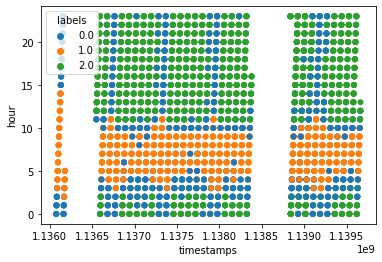

In [3]:
cfile = "clusters/ESTA.HHZ-ESTA.HHE_2.0-4.0Hz.gmmlabels.npy"
# plot the cluster labels
clusters = np.load(cfile)
dat = pd.DataFrame(columns=["timestamps", "labels"])
dat["timestamps"] = clusters[0]
dat["labels"] = clusters[1]
dat["hour"] = [float(UTCDateTime(t).strftime("%H")) for t in dat["timestamps"]]
sns.scatterplot(x="timestamps", y="hour", data=dat, hue="labels", linewidth=0,
                palette=sns.color_palette(n_colors=len(dat.labels.unique())),
                )


In [ ]:
# plot some waveforms
dset = CCDataset_serial("data/TO.ESTA.01.HHZ--TO.ESTA.01.HHE.ccc.windows.h5")
dset.data_to_memory(ix_corr_max=100)

In [ ]:
dset.dataset[0].filter_data(f_hp=config["freq_bands"][0][0],
                            f_lp=config["freq_bands"][0][1],)

In [ ]:
dset.dataset[0].add_cluster_labels(clusters)


In [ ]:
dset.plot_stacks(stacklevel=0,cluster_label=3, mask_gaps=1, lag_min=-5, lag_max=5)